In [1]:
from tensorflow.keras import models, layers
import tensorflow as tf
import matplotlib.pyplot as plt

2024-05-23 16:58:20.043493: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 16:58:20.043738: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-23 16:58:20.046607: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-23 16:58:20.084248: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 16:58:20.900489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


2024-05-23 16:58:23.631036: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 16:58:23.631460: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

2024-05-23 16:58:26.909890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


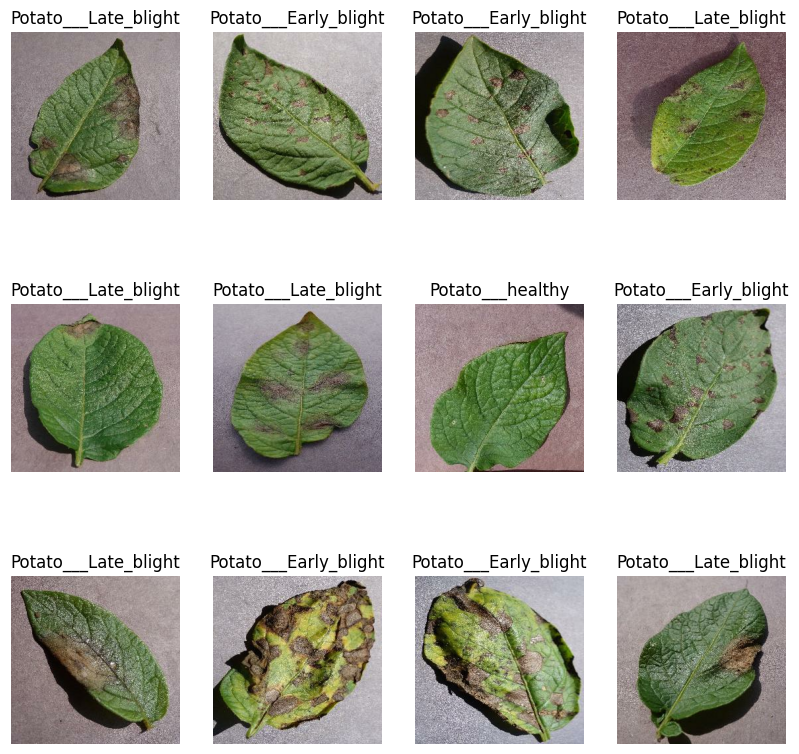

In [5]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  tr_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  tst_ds = ds.skip(train_size).skip(val_size)

  return tr_ds, val_ds, tst_ds

In [7]:
tr_ds, val_ds, tst_ds = get_dataset_partitions_tf(dataset)

In [8]:
tr_ds = tr_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
tst_ds = tst_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [9]:
resize_n_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255),
])

In [10]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [11]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_n_rescale,
    data_aug,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

/home/justnik/potato-disease/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [14]:
model_history = model.fit(
    tr_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 645ms/step - accuracy: 0.4757 - loss: 0.9602 - val_accuracy: 0.7188 - val_loss: 0.6967
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 648ms/step - accuracy: 0.7086 - loss: 0.7367 - val_accuracy: 0.7812 - val_loss: 0.5488
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 686ms/step - accuracy: 0.8115 - loss: 0.4863 - val_accuracy: 0.8646 - val_loss: 0.3609
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 681ms/step - accuracy: 0.8716 - loss: 0.3303 - val_accuracy: 0.9115 - val_loss: 0.2056
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 685ms/step - accuracy: 0.9018 - loss: 0.2637 - val_accuracy: 0.8906 - val_loss: 0.2312
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 686ms/step - accuracy: 0.8985 - loss: 0.2500 - val_accuracy: 0.9167 - val_loss: 0.2247
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 684ms/step - accuracy: 0.9232 - loss: 0.1925 - val_accuracy: 0.9219 - val_loss: 0.2324
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 685ms/step - accuracy: 0.9218 - loss: 0.1896 - val_accu

In [16]:
scores = model_history.evaluate(tst_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.9910 - loss: 0.0401


In [17]:
scores

[0.038743916898965836, 0.9921875]

In [18]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

TypeError: 'History' object is not subscriptable

NameError: name 'acc' is not defined

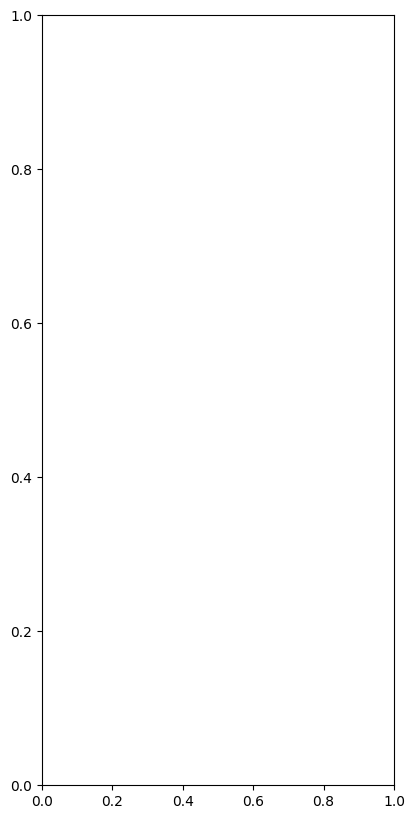

In [18]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Predicted label: Potato___Early_blight


2024-05-23 17:00:01.728589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


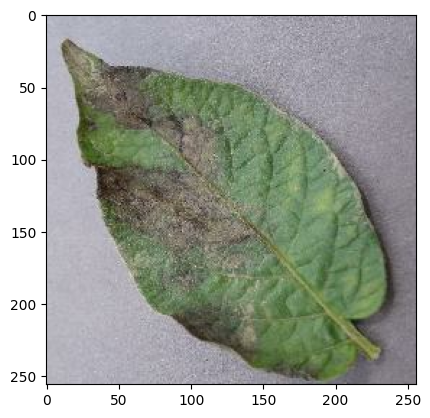

In [19]:
import numpy as np
for images_batch, labels_batch in tst_ds.take(1):

  first_image = images_batch[0].numpy().astype("uint8")
  first_label = labels_batch[0].numpy()

  print("First image to predict")
  plt.imshow(first_image)
  print("Actual label:", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

In [20]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2024-05-23 17:00:14.799190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


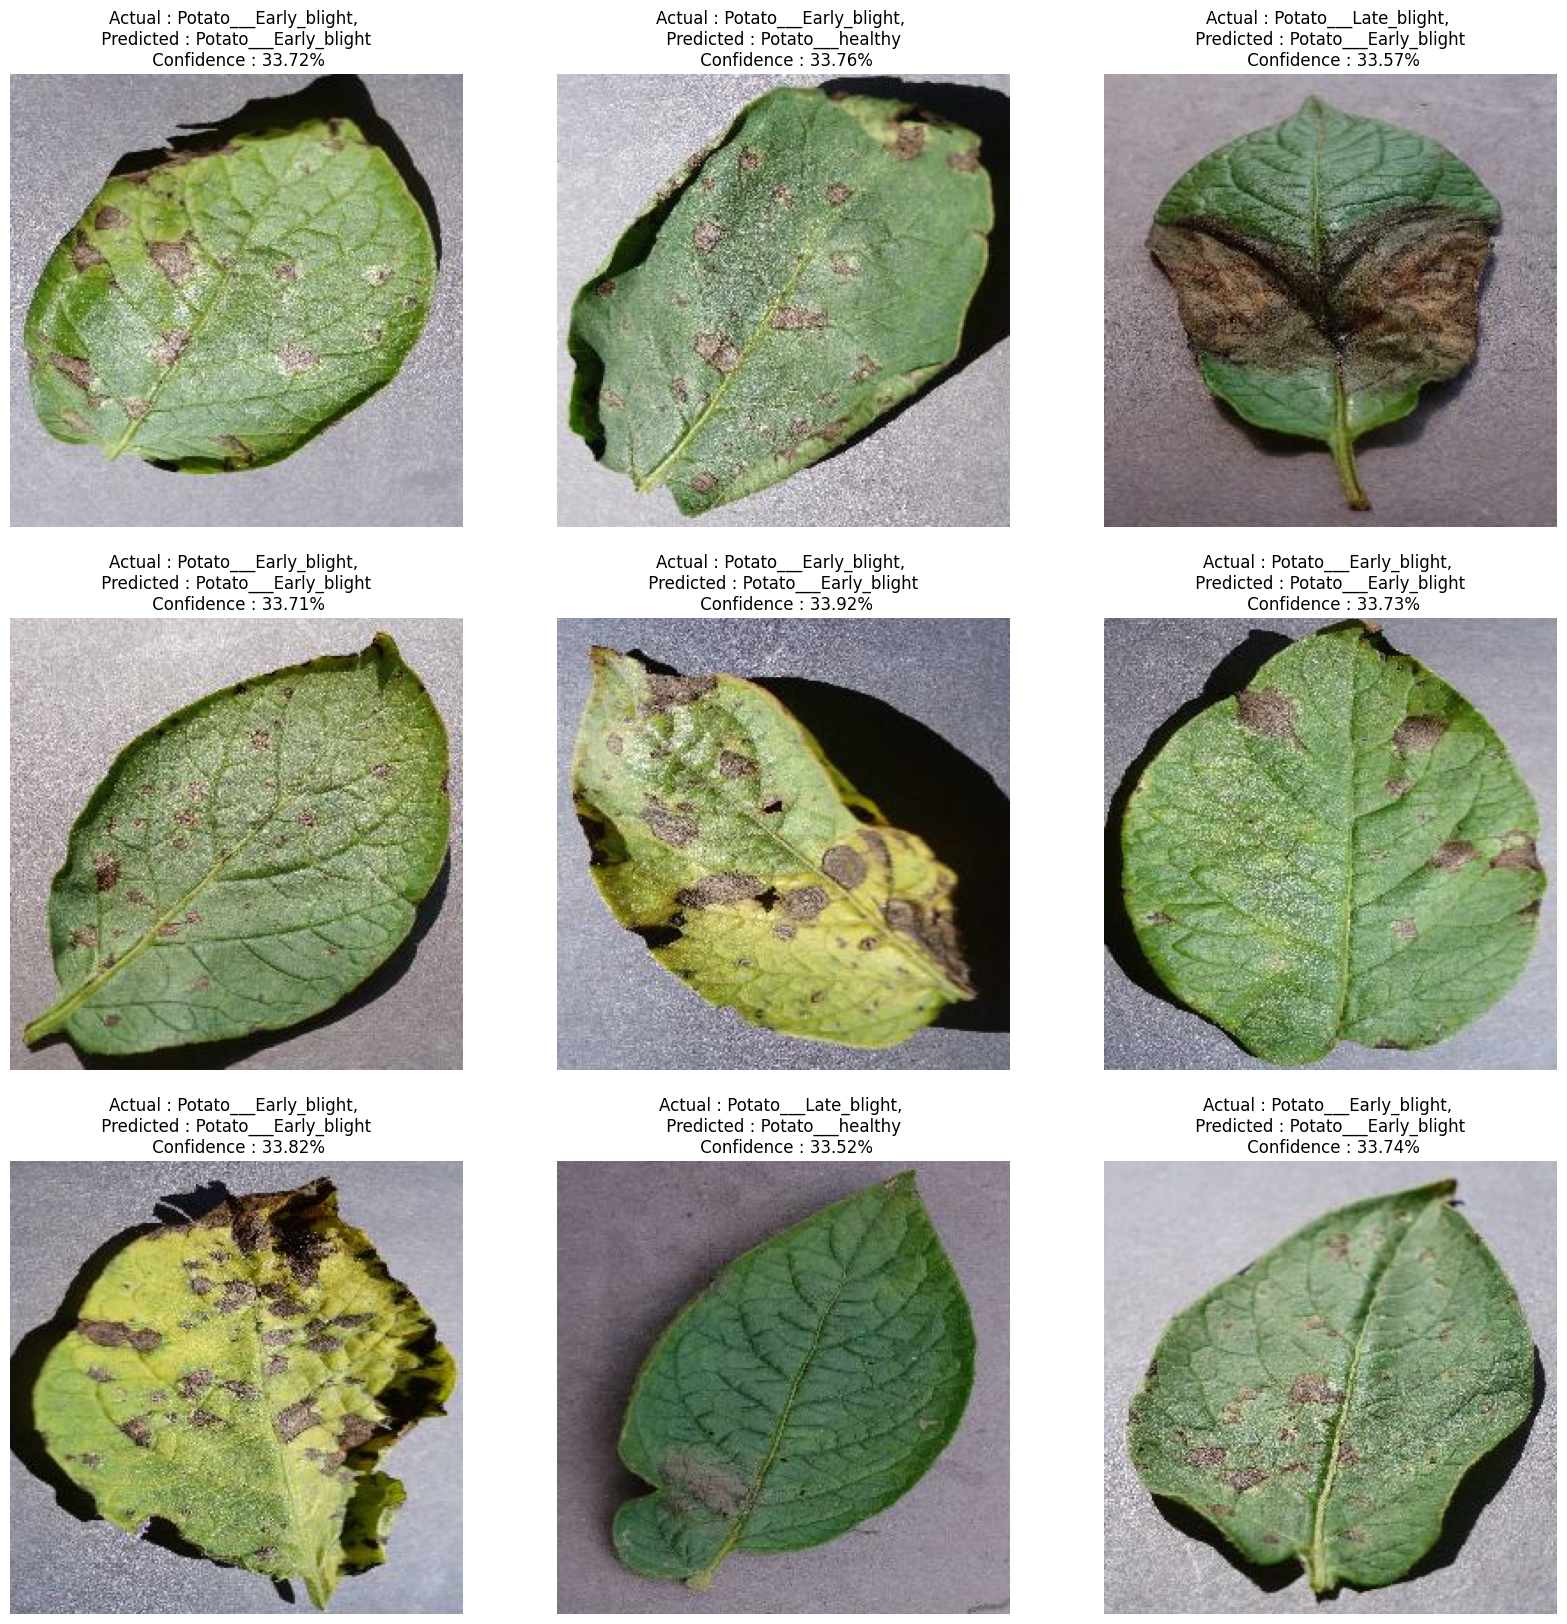

In [21]:
plt.figure(figsize = (20,20))
for images, labels in tst_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual : {actual_class}, \n Predicted : {predicted_class} \n Confidence : {confidence}%")
    plt.axis("off")

In [3]:
import os

# Get list of files in the directory
files = os.listdir("../saved_models/")

# Extract numeric parts from filenames and convert to integers
model_versions = [int(f.split('.')[0]) for f in files if f.endswith('.keras')]

# Determine the next model version number
next_model_version = max(model_versions + [0]) + 1

print(next_model_version)

model.save(f"../saved_models/{next_model_version}.keras")

3


TypeError: cannot pickle 'module' object

In [15]:
model_history = models.load_model("../saved_models/1.keras")